In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

In [ ]:
def load_sequence(file_path):
    """Loads a sequence from a FASTA file."""
    with open(file_path, 'r') as file:
        next(file)  # Skip header
        return ''.join(line.strip() for line in file)

def load_bwt(file_path):
    """Loads the last column of the BWT from file."""
    with open(file_path, 'r') as file:
        return file.read().replace('\n', '')

def load_bwt_map(file_path):
    """Loads the BWT mapping from file."""
    with open(file_path, 'r') as file:
        return [int(line.strip()) for line in file]

#______________________________________________________________
reference_sequence = load_sequence('/home/sahilc/Desktop/Genomics/chrX.fa')
# bwt_sequence = load_bwt('/content/drive/MyDrive/chrX_bwt/chrX_last_col.txt')
# bwt_map = load_bwt_map('/content/drive/MyDrive/chrX_bwt/chrX_map.txt')

print("Data Loaded Successfully")
print("Reference Sequence Length:", len(reference_sequence))
# print("BWT Sequence Length:", len(bwt_sequence))
# print("BWT Map Length:", len(bwt_map))

Data Loaded Successfully
Reference Sequence Length: 151100560


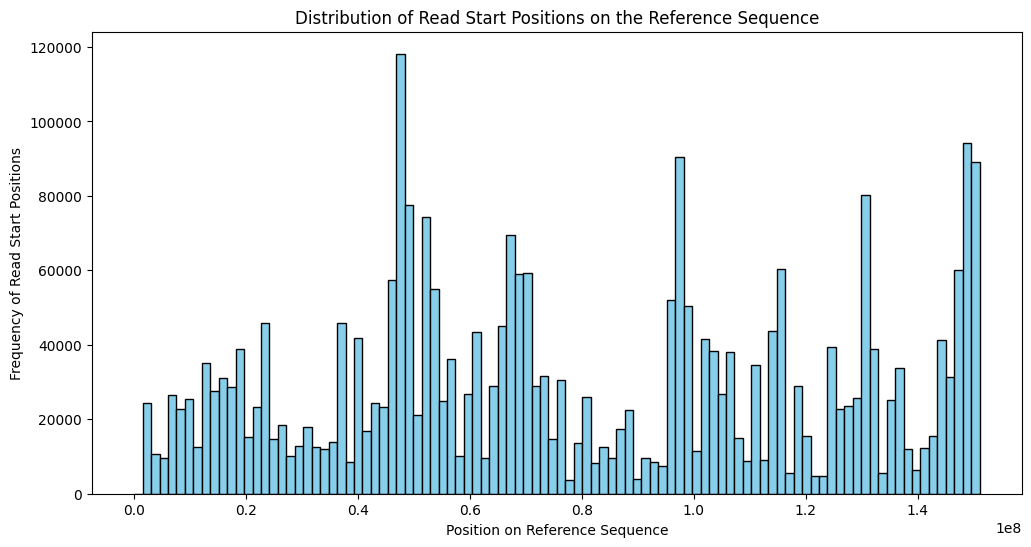

In [3]:
import pandas as pd
import matplotlib.pyplot as plt
 
# Load the CSV file into a DataFrame
df = pd.read_csv("/home/sahilc/Desktop/Genomics/data_list_5.csv")
 
# Remove rows where 'pos' is 'Nil' or NaN
df = df[df['pos'].str.lower() != 'nil']  # Keep rows where 'pos' is not 'Nil'
df['pos'] = df['pos'].astype(int)  # Convert 'pos' to integer
 
# Plotting a histogram of the read start positions
plt.figure(figsize=(12, 6))
plt.hist(df['pos'], bins=100, color='skyblue', edgecolor='black')  # Adjust 'bins' as needed for granularity
 
# Adding labels and title
plt.xlabel('Position on Reference Sequence')
plt.ylabel('Frequency of Read Start Positions')
plt.title('Distribution of Read Start Positions on the Reference Sequence')
plt.show()
 

In [4]:
### We wish to figure out the exons regions in the reference sequence and later plot the histogram to visualise these exons regions

## df['pos'] contains the start position of the read on the reference sequence 

# find the coverage
# coverage is the measure of how many times a particular base in the genome is represented in the sequencing reads
# coverage = Total number of bases in the reads / Total number of bases in the reference genome

# Find the coverage array 

# For the coverage we need to find the end position of the read on the reference sequence. 
# For this we will use results.csv

# Load the CSV file into a DataFrame
dx = pd.read_csv("results.csv")


# There are no titles in the csv file, so we will add the titles to the columns as valid, start, length 
dx.columns = ['valid', 'start', 'length']
dx.head()

,valid,start,length
0,2,255609,101
1,-1,-1,101
2,1,445714,101
3,-1,-1,101
4,-1,-1,101


In [5]:
# remove the rows where valid is -1
dx = dx[dx['valid'] != -1]
print(f"Number of valid entries: {len(dx)}")

Number of valid entries: 2811348


In [6]:
print(len(df))

2952524


In [89]:
coverage_array = np.zeros(len(reference_sequence))

for i in range(len(dx)):
    start = dx['start'].iloc[i]
    length = dx['length'].iloc[i]
    end = start + length
    coverage_array[start:end] += 1

# Normalize the coverage array
coverage_array = coverage_array

# mean coverage
mean_coverage = np.mean(coverage_array)
print("Mean Coverage:", mean_coverage)

# standard deviation of coverage
std_coverage = np.std(coverage_array)
print("Standard Deviation of Coverage:", std_coverage)


Mean Coverage: 1.8745954283690278
Standard Deviation of Coverage: 14.002313644737756


In [90]:
max_element = np.max(coverage_array)
print("Max Coverage:", max_element)

Max Coverage: 1206.0


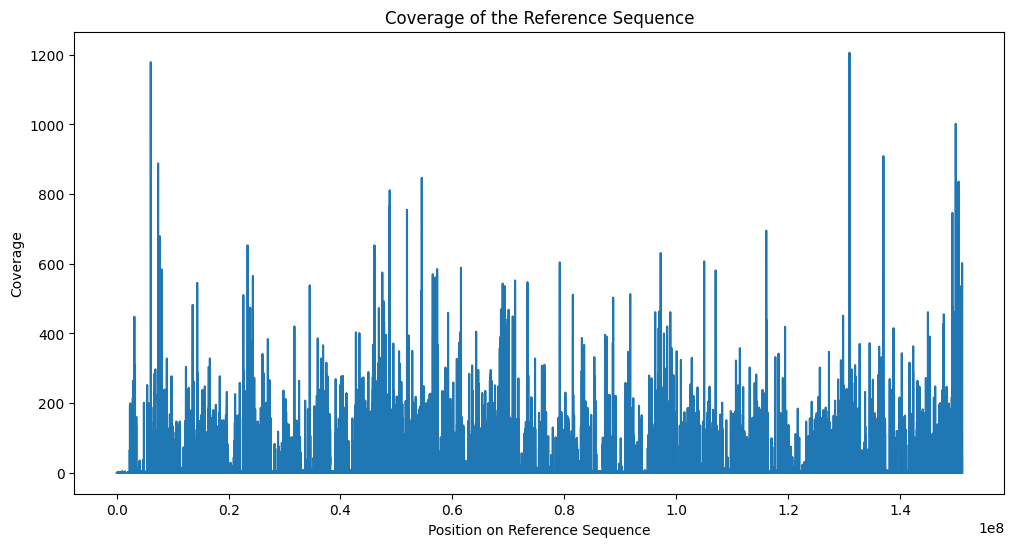

In [91]:
# plot the histogram of coverage array where x-axis is the position on the reference sequence and y-axis is the coverage at that position
plt.figure(figsize=(12, 6))
plt.plot(coverage_array)
plt.xlabel('Position on Reference Sequence')
plt.ylabel('Coverage')
plt.title('Coverage of the Reference Sequence')
plt.show()

In [129]:
sensititvity = 8
coverage_threshold = mean_coverage + sensititvity * std_coverage
print("Coverage Threshold:", coverage_threshold)

Coverage Threshold: 113.89310458627108


In [130]:
# Find the exons regions, which is basically the regions where the coverage is greater than the coverage threshold
# we iterate through the coverage array to find the exons regions

exon_regions = []
in_exon = False
start = 0

for i in range(len(coverage_array)):
    if coverage_array[i] > coverage_threshold:
        if not in_exon:
            start = i
            in_exon = True
    else:
        if in_exon:
            end = i-1
            if (end-start+1)>=10 and (end-start+1)<=500: # based on the biological knowledge, we can set the minimum length of the exon to be 50
                exon_regions.append((start, end))
            in_exon = False

if in_exon and (len(coverage_array)-start+1)>=50 and (len(coverage_array)-start+1)<=500:
    exon_regions.append((start, len(coverage_array)-1))

# Edit the exon region based on the ending point of a exon and starting point of a exon
# There can be a chance that we have missed some parts due to our statistical threshold
# to compensate for the same, we will check if the distance between the end of one exon and start of the next exon is less than 50
# if yes, we will merge the two exons

# new_exon_regions = []
# for i in range(len(exon_regions)-1):
#     if exon_regions[i+1][0] - exon_regions[i][1] < 50:
#         new_exon_regions.append((exon_regions[i][0], exon_regions[i+1][1]))
#     else:
#         new_exon_regions.append(exon_regions[i])

# if len(exon_regions) > 0:
#     new_exon_regions.append(exon_regions[-1])

# exon_regions = new_exon_regions

print("Number of Exons Regions:", len(exon_regions))




Number of Exons Regions: 2468


In [131]:
# length of the exons regions
exon_lengths = [end-start+1 for start, end in exon_regions]
print("Exon Lengths:", exon_lengths)

average_exon_length = np.mean(exon_lengths)
print("Average Exon Length:", average_exon_length)

Exon Lengths: [26, 96, 27, 275, 133, 102, 64, 20, 18, 141, 65, 12, 40, 28, 167, 286, 299, 263, 360, 23, 12, 344, 102, 202, 378, 32, 81, 191, 218, 262, 15, 263, 136, 15, 10, 452, 378, 362, 245, 56, 25, 495, 49, 169, 15, 15, 226, 322, 100, 124, 243, 287, 360, 173, 239, 279, 354, 288, 45, 194, 395, 104, 184, 293, 45, 10, 11, 435, 362, 92, 85, 47, 244, 233, 188, 211, 222, 197, 212, 359, 149, 263, 111, 11, 441, 259, 15, 102, 158, 130, 104, 59, 91, 45, 50, 20, 22, 230, 116, 17, 43, 325, 209, 73, 36, 28, 13, 86, 79, 23, 16, 127, 175, 175, 82, 76, 58, 91, 18, 139, 86, 18, 393, 105, 142, 69, 112, 85, 251, 21, 193, 129, 174, 264, 237, 27, 44, 124, 182, 108, 42, 468, 41, 111, 32, 68, 41, 377, 371, 322, 125, 246, 69, 100, 42, 74, 26, 10, 19, 242, 98, 250, 265, 381, 16, 348, 480, 19, 11, 17, 42, 113, 117, 405, 26, 77, 96, 28, 242, 55, 407, 24, 70, 122, 30, 113, 274, 22, 26, 15, 110, 86, 285, 17, 34, 44, 75, 19, 18, 11, 21, 268, 40, 41, 53, 55, 88, 15, 17, 66, 14, 176, 117, 96, 14, 110, 31, 71, 14, 

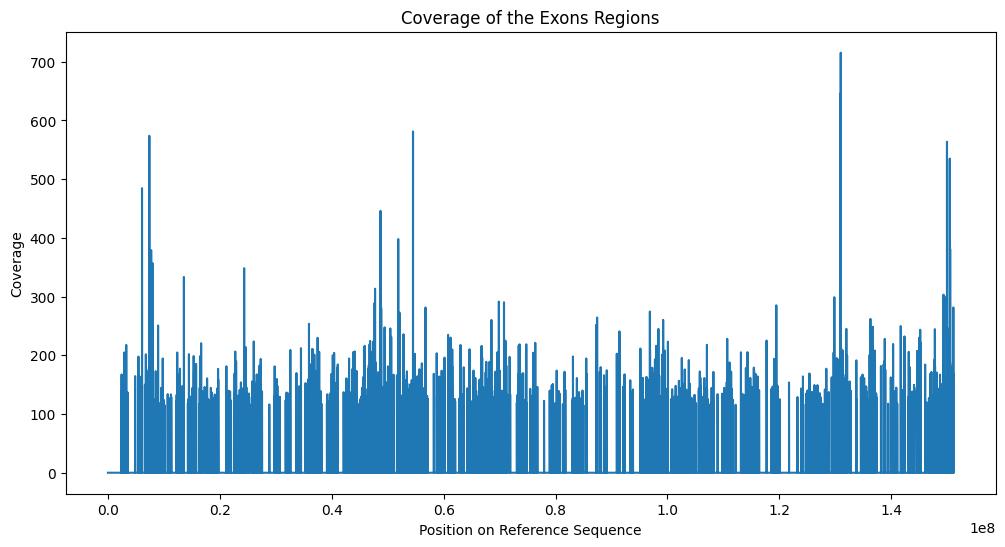

In [132]:
coverage_exons = np.zeros(len(reference_sequence))

for start, end in exon_regions:
    average_coverage = np.mean(coverage_array[start:end+1])
    coverage_exons[start:end+1] = average_coverage
    # coverage_exons[start:end+1] += 1

plt.figure(figsize=(12, 6))
plt.plot(coverage_exons)
plt.xlabel('Position on Reference Sequence')
plt.ylabel('Coverage')
plt.title('Coverage of the Exons Regions')
plt.show()


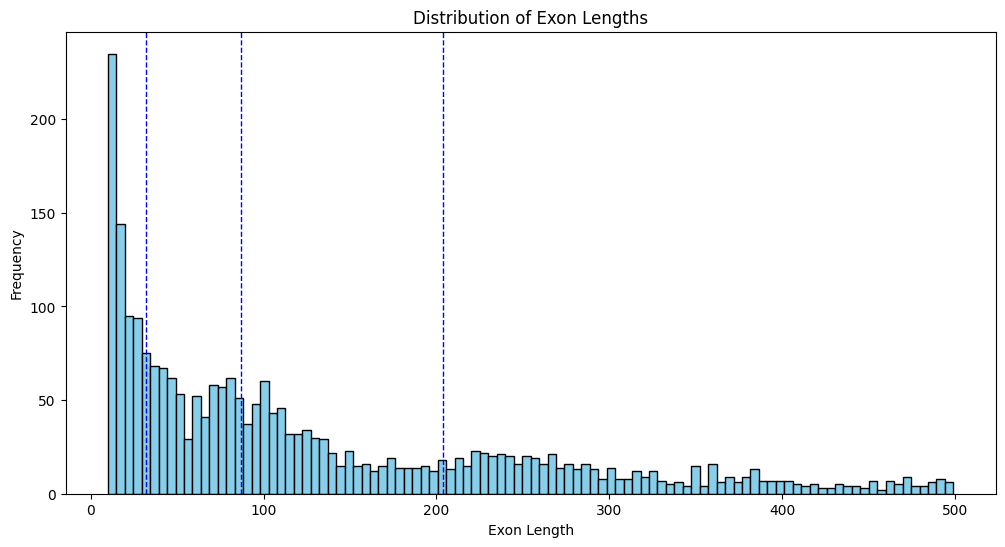

In [133]:
# Bar plot of the exon lengths
plt.figure(figsize=(12, 6))
plt.hist(exon_lengths, bins=100, color='skyblue', edgecolor='black')
plt.xlabel('Exon Length')
plt.ylabel('Frequency')
plt.title('Distribution of Exon Lengths')
# draw the quartiles on the plot
plt.axvline(np.percentile(exon_lengths, 25), color='blue', linestyle='dashed', linewidth=1)
plt.axvline(np.percentile(exon_lengths, 50), color='blue', linestyle='dashed', linewidth=1)
plt.axvline(np.percentile(exon_lengths, 75), color='blue', linestyle='dashed', linewidth=1)
plt.show()
